<a href="https://colab.research.google.com/github/VAEs-Tutorial/paper/blob/master/INFO_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.7.0

     |████████████████████████████████| 48.0MB 69kB/s 
     |████████████████████████████████| 3.1MB 67.5MB/s 
     |████████████████████████████████| 890kB 65.1MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=750bbff4214b5caa38f228eec98a57e03e236517e8a446cfc7d87b084fdbe51f
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.5
    Uninstalling bleach-3.1.5:
      Successfully uninstalled bleach-3.1.5
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os
# Define some handy network layers
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [3]:
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])])
        fc1 = fc_lrelu(conv2, 1024)
        return tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)

In [4]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        output = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        return output
        

In [5]:
z_dim = 20
train_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
train_z = encoder(train_x, z_dim)
train_xr = decoder(train_z)

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x = decoder(gen_z, reuse=True)

In [7]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
true_samples = tf.random_normal(tf.stack([200, z_dim]))
loss_mmd = compute_mmd(true_samples, train_z)

In [8]:
loss_nll = tf.reduce_mean(tf.square(train_xr - train_x))
loss = loss_nll + loss_mmd
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [35]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
batch_size = 100
sess = tf.Session()
sess.run(tf.global_variables_initializer())


Negative log likelihood is 0.016941, mmd loss is 0.002114


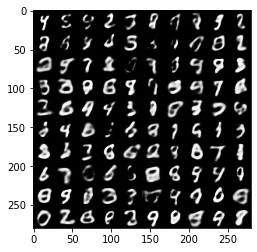

Negative log likelihood is 0.013127, mmd loss is 0.002025
Negative log likelihood is 0.010797, mmd loss is 0.002305
Negative log likelihood is 0.009370, mmd loss is 0.000965
Negative log likelihood is 0.008809, mmd loss is 0.001039


In [38]:

for i in range(500):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    _, nll, mmd = sess.run([trainer, loss_nll, loss_mmd], feed_dict={train_x: batch_x})
    if i % 100 == 0:
        print("Negative log likelihood is %f, mmd loss is %f" % (nll, mmd))
        
    if i % 500 == 0:
        samples = sess.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()

